In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('/Users/daniel/Princeton Dropbox/Daniel Gurevich/Research/discrete_sr/code/SPIDER_discrete')

In [2]:
import numpy as np

from commons.weight import *
from commons.utils import save, load
from library import *
from process_library_terms import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
positions, vs, deltat, dims = load('Matt/sim_n64_v03.npy', 4)
deltat
print(positions.shape, vs.shape, deltat, dims)

Np, nt = positions.shape[0], positions.shape[2]
world_size = np.array([dims[0], dims[0], dims[1]])
print(world_size)

(1024, 2, 128) (1024, 2, 128) 0.003662109375 [  1 128]
[  1   1 128]


0
0
0
0
10
20
30
40
50
60
70
80
90
100
110
120


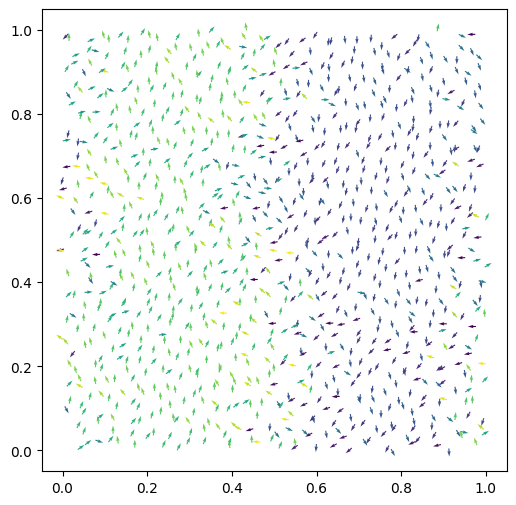

In [4]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/Users/daniel/Documents/ffmpeg-7.1/ffmpeg'

vid_file = 'Matt/sim_n64_v03.mp4'

fig, ax = plt.subplots(figsize=(6, 6))
qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

def animate(i):
    if i % 10 == 0:
        print(i)
    qv.set_offsets(positions[:, :, i])
    norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
    qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
    return qv,

anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

In [5]:
%%prun # profiling

data_dict = {}
data_dict['v'] = vs
v_obs = Observable(string='v', rank=1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
corr_L = 0.05
kernel_sigma = 0.05 # 0.02
cg_res = 256
srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables, 
                irreps=SRDataset.all_rank2_irreps(), kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)
v_est = np.mean(np.abs(vs))*2**0.5
print(v_est)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3, max_rho=2)
srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
#srd.make_libraries(max_complexity=6, max_observables=4)

dom_width = 0.3
dom_time = 40
srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4) #*8
srd.make_weights(m=8, qmax=1)
srd.set_LT_scale(L=corr_L, T=corr_L/v_est) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

save('Q_gauss1024.npy', srd)

0.8065285682631045
 

         60770835 function calls (57983883 primitive calls) in 73.001 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2130   40.486    0.019   40.491    0.019 coarse_grain_utils.py:267(poly_coarse_grain_time_slices)
   319680    5.020    0.000    5.191    0.000 polynomial.py:672(polyval)
   319680    2.213    0.000    3.172    0.000 _function_base_impl.py:5078(trapezoid)
   125280    1.366    0.000    1.676    0.000 numeric.py:978(tensordot)
   233760    1.319    0.000    3.622    0.000 arrayprint.py:966(fillFormat)
   106560    1.248    0.000   45.917    0.000 process_library_terms.py:399(eval_term)
   820487    1.215    0.000    1.215    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   319680    1.172    0.000    1.676    0.000 function_base.py:25(linspace)
     9090    1.162    0.000    1.167    0.000 diff.py:479(_apply_to_array)
1181280/233760    1.111    0.000    2.593    0.000 arrayprint.py:815(recurser)
   10

In [6]:
# %%prun # profiling

# data_dict = {}
# data_dict['v'] = vs
# v_obs = Observable(string='v', rank=1)
# observables = [v_obs]

# # fix random seed
# np.random.seed(1)

# # initial setup of dataset
# corr_L = 0.05#0.3
# kernel_sigma = 0.02#0.05
# cg_res = 256
# srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables, 
#                 irreps=SRDataset.all_rank2_irreps(), kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)
# v_est = np.mean(np.abs(vs))*2**0.5
# print(v_est)

# # initialize libraries, domains, and weights
# #srd.make_libraries(max_complexity=4, max_observables=3, max_rho=2)
# srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
# #srd.make_libraries(max_complexity=6, max_observables=4)

# dom_width = 0.3
# dom_time = 20
# srd.make_domains(ndomains=15, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4) #*8
# srd.make_weights(m=8, qmax=1)
# srd.set_LT_scale(L=corr_L, T=corr_L/v_est) # note that this line must go before make_library_matrices
# srd.make_library_matrices(debug=False)

# save('Q_gauss1024.npy', srd.dxs, srd.libs)

In [15]:
from commons.identify_models import *
import copy

#srd = load('Q_gauss1024.npy', 1)
libs = srd.libs

reg_opts_list = []
for irrep in srd.irreps:
    # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
    scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=0.8)
    #init = Initializer(method='combinatorial', start_k=3)
    #init = Initializer(method='combinatorial', start_k=9999)
    init = Initializer(method='power', start_k=10)
    #res = Residual(residual_type='fixed_column', anchor_col=0)
    res = Residual(residual_type='dominant_balance')
    #res = Residual(residual_type='matrix_relative')
    
    iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=10)
    thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
    #thres = Threshold(threshold_type='information', ic=AIC)
    
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False
    opts['inhomog'] = False
    opts['inhomog_col'] = None
    reg_opts_list.append(opts)

eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
#eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in range(len(irreps))], 
reg_opts_list, threshold=3e-1, experimental=True)
#, max_equations=10)

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
A: [[ 10.614  11.829  -1.667]
 [ 11.829  14.323  -0.996]
 [ -1.667  -0.996 263.063]] and V: [[-0.007 -0.004  1.   ]
 [-0.65  -0.76  -0.008]
 [ 0.76  -0.65   0.002]]
A: [[ 10.614  11.829  -1.667]
 [ 11.829  14.323  -0.996]
 [ -1.667  -0.996 263.063]] and V: [[-0.007 -0.004  1.   ]
 [-0.65  -0.76  -0.008]
 [ 0.76  -0.65   0.002]]
A: [[ 4.893e-01 -1.458e+00]
 [ 7.836e-03  4.766e-05]
 [ 4.626e-03  1.001e-02]
 [-6.400e-04  2.707e-02]
 [ 4.281e-02 -1.163e-01]
 [ 1.239e-01  8.909e-01]
 [ 5.253e-02 -1.785e-01]
 [ 1.382e-01 -4.460e-01]
 [ 1.246e-05  2.300e-02]
 [-2.947e-03  3.196e-02]
 [ 3.636e-02 -7.384e-02]
 [-1.662e-01  5.303e-01]
 [ 8.928e-03 -5.064e-02]
 [

In [8]:
lib1 = libs[srd.irreps[1]]
for i, term, size in zip(list(range(len(lib1.terms))), lib1.terms, lib1.col_weights):
    print(i, term, size, term.complexity)
print(next(regex_find(lib1.terms, r'∂t ρ\[v_α\]')))
print(next(regex_find(lib1.terms, r'ρ · ∂t ρ\[v_α\]')))

0 ρ · ∂α ρ 986870.418762003 3
1 ρ · ∂α ∂β² ρ 394748167.5048011 5
2 ρ · ∂t ∂α ρ 15918783.718106572 4
3 ρ · ∂t² ∂α ρ 256779076.81309023 5
4 ρ · ρ[v_α] 731015.1123880195 3
5 ρ · ∂β² ρ[v_α] 13759374.88057568 5
6 ρ · ∂α ∂β ρ[v_β] 13759374.88057568 5
7 ρ · ∂t ρ[v_α] 554866.4461313015 4
8 ρ · ∂t² ρ[v_α] 8950312.80751031 5
9 ρ · ∂β ρ[v_α · v_β] 479597.9125144753 5
10 ρ · ∂α ρ[v_β · v_β] 479597.9125144753 5
11 ρ · ρ[v_α · v_β · v_β] 355286.93653138686 5
12 ∂α ρ 963.7406433222685 2
13 ∂β ρ · ∂α ∂β ρ 18575920.5518244 5
14 ∂α ρ · ∂β² ρ 18575920.5518244 5
15 ∂α ρ · ∂t ρ 749100.5303416055 4
16 ∂α ρ · ∂t² ρ 12083419.564430946 5
17 ∂α ρ · ∂β ρ[v_β] 647483.8280819467 5
18 ∂β ρ · ∂α ρ[v_β] 647483.8280819467 5
19 ∂β ρ · ∂β ρ[v_α] 647483.8280819467 5
20 ∂α ρ · ρ[v_β · v_β] 479637.3725982429 5
21 ∂β ρ · ρ[v_α · v_β] 479637.3725982429 5
22 ∂α ∂β ρ · ρ[v_β] 13759940.911936134 5
23 ∂β² ρ · ρ[v_α] 13759940.911936134 5
24 ∂α ∂β² ρ 385496.2573289073 4
25 ∂t ρ · ∂t ∂α ρ 12083419.564430945 5
26 ∂t ρ · ρ[v_α] 55488

In [9]:
lib0 = libs[srd.irreps[0]]
for i, term, size in zip(list(range(len(lib0.terms))), lib0.terms, lib0.col_weights):
    print(i, term, size, term.complexity)
print(next(regex_find(lib0.terms, r'∂α² ρ')))
print(next(regex_find(lib0.terms, r'∂t² ρ')))
print(next(regex_find(lib0.terms, r'∂t ∂α ρ\[v_α\]')))
print(next(regex_find(lib0.terms, r'ρ · ∂α² ρ')))

0 ρ 1024.0 1
1 ρ · ρ 1048576.0 2
2 ρ · ∂α² ρ 19737408.375240054 4
3 ρ · ∂t ρ 795939.1859053286 3
4 ρ · ∂t ∂α² ρ 318375674.36213136 5
5 ρ · ∂t² ρ 12838953.840654511 4
6 ρ · ∂t³ ρ 207099661.18198338 5
7 ρ · ∂α ρ[v_α] 687968.7440287841 4
8 ρ · ∂t ∂α ρ[v_α] 11097328.922626028 5
9 ρ · ρ[v_α · v_α] 509627.432384175 4
10 ρ · ∂t ρ[v_α · v_α] 386809.4177222734 5
11 ∂α ρ · ∂α ρ 928796.02759122 4
12 ∂α ρ · ∂t ∂α ρ 14982010.60683211 5
13 ∂α ρ · ρ[v_α] 687997.0455968069 4
14 ∂α ρ · ∂t ρ[v_α] 522214.20483644656 5
15 ∂α² ρ 19274.812866445365 3
16 ∂α² ρ · ∂t ρ 14982010.606832106 5
17 ∂α² ∂β² ρ 7709925.146578147 5
18 ∂t ρ 777.2843612356725 2
19 ∂t ρ · ∂t ρ 604170.9782215473 4
20 ∂t ρ · ∂t² ρ 9745623.081022875 5
21 ∂t ρ · ∂α ρ[v_α] 522214.20483644656 5
22 ∂t ρ · ρ[v_α · v_α] 386841.24340713804 5
23 ∂t ∂α ρ · ρ[v_α] 11097785.44308877 5
24 ∂t ∂α² ρ 310913.7444942689 4
25 ∂t² ρ 12538.04086001417 3
26 ∂t² ∂α² ρ 5015216.344005668 5
27 ∂t³ ρ 202245.76287303065 4
28 ∂t⁴ ρ 3262339.7113452945 5
29 ρ[v_α] · ρ[v_α

In [10]:
print(reg_results[2].all_lambdas, reg_results[2].all_lambdas_test)

[0.075 0.075 0.075 0.075 0.075 0.075 0.075 0.075 0.075 0.075] [0.505 0.505 0.505 0.505 0.505 0.505 0.505 0.505 0.505 0.505]


In [11]:
scaler = Scaler(sub_inds=None, char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
init = Initializer(method='combinatorial', start_k=2)
#init = Initializer(method='combinatorial', start_k=9999)
#init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
res = Residual(residual_type='dominant_balance')
#res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=10, backward_forward=True, brute_force=True, max_passes=10)
thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
opts['inhomog_col'] = 15 # ∂α² ρ
#opts['inhomog_col'] = 25 # ∂t² ρ

#remove_terms = [7] # rho * dt rho[v_i]
remove_terms = [34, 2] # ∂t ∂α ρ[v_α], ρ · ∂α² ρ
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib0.Q, **opts)
zipped = [(lib0.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)

RECOMPUTING xi: [ 0.     0.     0.     0.     0.036  0.     0.     0.     0.     0.
  0.     0.     0.     0.    -1.     0.    -0.062  0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ] = solve([ 0.229  0.228  0.558  0.979  1.92  14.147  0.645  2.222  0.524  6.451
  0.103  0.315  0.15   2.402  0.183  0.495  2.041  0.558  2.272  4.761
  2.629  1.208  0.647  0.985  1.934  5.65  14.062 58.177  0.391  3.519
  0.645  1.14   1.14  16.257  0.529  5.38   2.016  6.425 22.429  4.881], [np.int64(14), np.int64(16), 4], 14)
RECOMPUTING xi: [ 0.     0.     0.     0.     0.046  0.     0.     0.     0.     0.
  0.     0.     0.     0.    -1.     0.    -0.046  0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    -0.045  0.     0.     0.   ] = solve([ 0.229  0.228  0.558  0.979  1.92  14.147  0.645  2.222  0.524  6.451
  0.10

In [12]:
scaler = Scaler(sub_inds=None, char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
init = Initializer(method='combinatorial', start_k=2)
#init = Initializer(method='combinatorial', start_k=9999)
#init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
res = Residual(residual_type='dominant_balance')
#res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=10, backward_forward=True, brute_force=True, max_passes=10)
thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
opts['inhomog_col'] = 41 # dt rho[v_i]

remove_terms = [7] # rho * dt rho[v_i]
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib1.Q, **opts)
zipped = [(lib1.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)

RECOMPUTING xi: [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 -1.    -0.255  0.     0.     0.     0.     0.     0.     0.     0.
  0.148] = solve([ 0.247  0.95   0.943  5.267  0.494  8.686  1.091 22.05   5.436  7.078
  1.503  0.252  0.144  0.218  0.517  2.535  0.598  2.788  3.733  0.473
  0.293  0.255  0.337  0.959  2.444  1.24  14.729  0.944  4.533  4.44
  5.276 42.313  0.495  1.435  4.533  4.942  1.262  1.08   1.092  8.562
  6.312  8.934  6.104 21.964 87.915  5.466  7.089 11.541 10.797  1.518
 25.022], [np.int64(40), np.int64(50), 41], 40)
RECOMPUTING xi: [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.    -7.287  0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0. 

In [13]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['1', 'rho', 'rho * rho']
#continuity_terms = ['rho * rho[v_j * v_j]', 'rho[v_j] * rho[v_j]', 'rho']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

NameError: name 'find_term' is not defined